#  Внедрение системы компьютерного зрения для обработки фотографий покупателей

## Описание проекта

Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:
* Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
* Контролировать добросовестность кассиров при продаже алкоголя.

Постройте модель, которая по фотографии определит приблизительный возраст человека. В вашем распоряжении набор фотографий людей с указанием возраста.

## Ход работы

1. Провести исследовательский анализ данных, в ходе которого также подготовить данные к обучению, а также сделать выводы о качестве и о том, как результаты исследования повлияют на обучение модели.
2. Обучить модель нейронной сеть и рассчитайте её качество. Добиться метрики качества MAE не более 8.

## Исследовательский анализ данных

### Импорт библиотек

In [ ]:
from pandas import read_csv
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D

### Ознакомление с данными

Получим таблицу с целевым признаком и названиями файлов фотографий

In [ ]:
df = read_csv('/datasets/faces/labels.csv')
df.head()

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


Получение таблицы прошло без ошибок. Данные отображаются корректно

Ознакомимся с типами данных и наличием пропусков в данных

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


Типы данных соответсвуют содержимому, пропуски отсутствуют

Проверим наличие дубликатов названий файлов

In [ ]:
df['file_name'].duplicated().sum()

0

Дубликаты названий файлов отсутсвуют

### Общая статистика

Подготовим пользователькую функцию для получения гистрограммы, ящика с усами и статистики целевого признака

In [ ]:
def feed_info(df, column, xlabel='', ylabel='', bins=50):
    #(2 строки, 1 столбец)
    fig, axs = plt.subplots(2, 1, figsize=(7, 10))

    # Верхний график - гистограмма
    axs[0].hist(df[column], bins=bins)
    axs[0].set_title(f'Распределение по {column}')
    axs[0].set_xlabel(xlabel)
    axs[0].set_ylabel(ylabel)
    axs[0].grid(True)

    # Нижний график - ящик
    boxplot = sns.boxplot(data=df, x=column, ax=axs[1])
    boxplot.set_title(f'Ящик с усами для {column}')

    # Располагает графики более компактно
    plt.tight_layout()
    plt.show()

    # Теперь выведем общую статистику
    print(f'Статистика по {column}:')
    print(df[column].describe())

Вызовем разработанную функцию

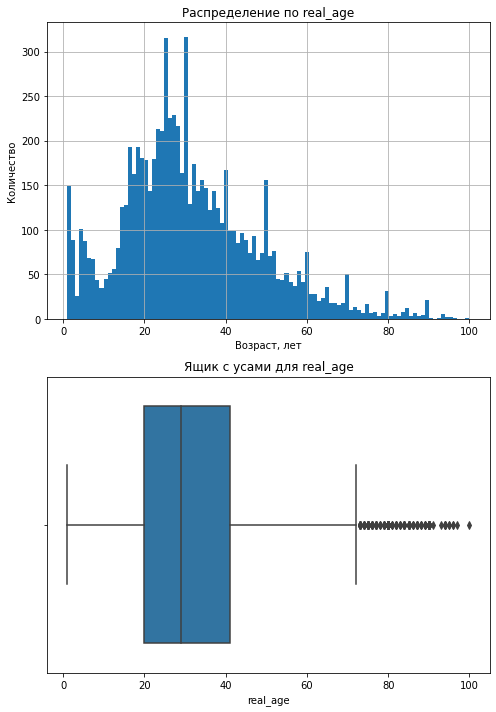

Статистика по real_age:
count    7591.000000
mean       31.201159
std        17.145060
min         1.000000
25%        20.000000
50%        29.000000
75%        41.000000
max       100.000000
Name: real_age, dtype: float64


In [ ]:
feed_info(df, 'real_age', 'Возраст, лет', 'Количество', 100)

В данных присутствуют относительно небольшое количество пожилых людей. Предсказывать их возраст для нейронной сеты может быть сложно.

Гораздо больше данных связано с маленькими детьми, которых, вероятно, будет проще распознать.

Чаще всего встречаются люди в возрасте от 20 до 41 года. Их возраст нейронная сеть должна распознавать лучше всего.

Выбросов в данных не наблюдается.

Некоторые близлежащие возрастные группы встречаются чуть чаще или реже, чем другие, что наводит на мысль,о том что размер выборки маловат с точки зрения равномерности. Стоит это учитывать и применять нормализацию в слоях нейронной сети, а также, возможно, регуляризацию.

### Отображение файлов

Подготовим новый признак в датасете, который будет содержать полный путь до файлов изображений

In [ ]:
df['image_path'] = '/datasets/faces/final_files/' + df['file_name']

Настроим объект ImageDataGenerator, который будет использоваться для  загрузки и обработки данных. Векторное представление данных будет нормализовано в диапазон от 0 до 1. Данные будут разделены на тренировочные и тестовые 3 к 1

In [ ]:
train_datagen = ImageDataGenerator(
    validation_split=0.25,
    rescale=1./255)

Подготовим генератор данных train_datagen_flow для обучения нейронной сети

In [ ]:
train_datagen_flow = train_datagen.flow_from_dataframe(
    dataframe=df,
    directory=None,
    x_col='image_path',
    y_col='real_age',
    target_size=(150, 150),
    batch_size=16,
    class_mode='raw',
    shuffle=True,
    seed=42)

Found 7591 validated image filenames.


Получим первый батч

In [ ]:
features, labels = next(train_datagen_flow)

Выведем изображения в первом батче

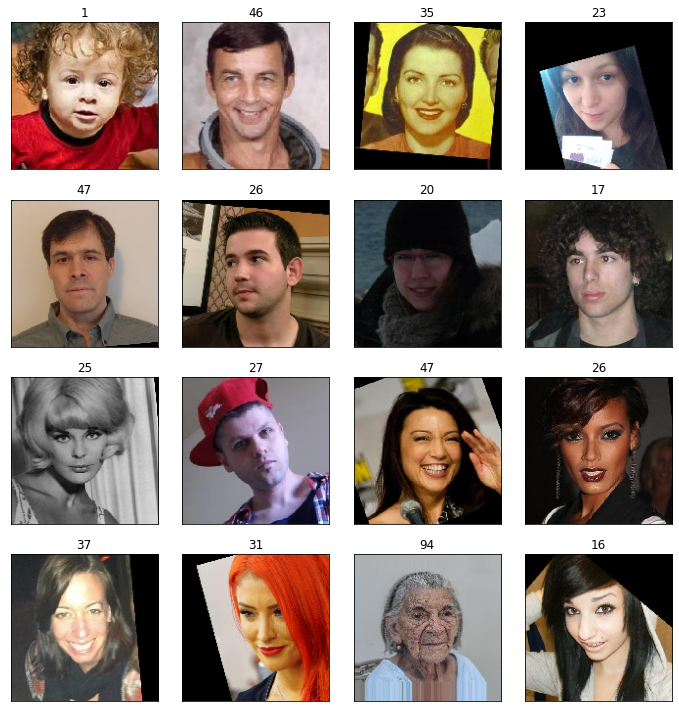

In [ ]:
# выводим 16 изображений
fig = plt.figure(figsize=(10,10))
for i in range(16):
    fig.add_subplot(4, 4, i+1)
    plt.imshow(features[i])
    # для компактности удаляем оси и прижимаем изображения друг к другу
    plt.xticks([])
    plt.yticks([])
    plt.title(f"{labels[i]}")
    plt.tight_layout()

Судя по всему, над данными уже была проведена аугментацией, поэтому делать ее не потребуется и создавать отдельный генератор данных для тестовой выборки не потребуется.

### Вывод

* Получение таблицы прошло без ошибок. Данные отображаются корректно
* Типы данных соответсвуют содержимому. Пропуски отсутствуют
* Дубликаты названий файлов отсутствуют
* Выбросы в данных отсутствуют
* Аугментация не требуется

## Обучение модели

### Функции работы с нейронной сетью

Подготовка тренировочных данных

In [ ]:
def load_train(path):

    df = read_csv(path + 'labels.csv')
    df['image_path'] = path + '/final_files/' + df['file_name']

    train_df, test_df = train_test_split(df, test_size=0.25, random_state=42)

    del test_df
    del df

    train_datagen = ImageDataGenerator(
        rescale=1. / 255,
        validation_split=0.25
    )
    train_datagen_flow = train_datagen.flow_from_dataframe(
        dataframe=train_df,
        directory=None,
        x_col='image_path',
        y_col='real_age',
        target_size=(150, 150),
        batch_size=16,
        class_mode='raw',
        shuffle=True,
        seed=42
    )

    return train_datagen_flow

Подготовка тестовых данных

In [ ]:
def load_test(path):

    df = read_csv(path + 'labels.csv')
    df['image_path'] = path + '/final_files/' + df['file_name']

    train_df, test_df = train_test_split(df, test_size=0.25, random_state=42)

    del train_df
    del df

    test_datagen = ImageDataGenerator(
        rescale=1. / 255
    )
    test_datagen_flow = test_datagen.flow_from_dataframe(
        dataframe=test_df,
        directory=None,
        x_col='image_path',
        y_col='real_age',
        target_size=(150, 150),
        batch_size=16,
        class_mode='raw',
        shuffle=False,
        seed=42
    )

    return test_datagen_flow

Создание модели нейронной сети

In [ ]:
def create_model(input_shape):

    backbone = ResNet50(input_shape=input_shape,
                        weights='/datasets/keras_models/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5',
                        include_top=False)

    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))
    model.compile(optimizer=Adam(lr=0.0003), loss='mse', metrics=['mae'])

    return model

Тренировка модели нейронной сети

In [ ]:
def train_model(model, train_datagen_flow, test_datagen_flow, batch_size=None, epochs=15, steps_per_epoch=None, validation_steps=None):
    if steps_per_epoch is None:
        steps_per_epoch = len(train_datagen_flow)
    if validation_steps is None:
        validation_steps = len(test_datagen_flow)

    model.fit(train_datagen_flow,
              validation_data=test_datagen_flow,
              epochs=epochs,
              batch_size=batch_size,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2,
              shuffle=True)

    return model

### Результат работы модели на сервере

    Found 5693 validated image filenames.
    Found 1898 validated image filenames.
    <class 'tensorflow.python.keras.engine.sequential.Sequential'>
    Train for 356 steps, validate for 119 steps
    Epoch 1/15
    356/356 - 56s - loss: 191.0712 - mae: 10.3325 - val_loss: 311.5738 - val_mae: 14.3643
    Epoch 2/15
    356/356 - 45s - loss: 96.0704 - mae: 7.5004 - val_loss: 224.1052 - val_mae: 11.2598
    Epoch 3/15
    356/356 - 44s - loss: 58.0975 - mae: 5.8150 - val_loss: 138.2220 - val_mae: 9.0216
    Epoch 4/15
    356/356 - 44s - loss: 35.7882 - mae: 4.6124 - val_loss: 101.8552 - val_mae: 7.6673
    Epoch 5/15
    356/356 - 46s - loss: 22.2546 - mae: 3.6298 - val_loss: 101.3223 - val_mae: 7.4575
    Epoch 6/15
    356/356 - 47s - loss: 16.7740 - mae: 3.1709 - val_loss: 109.6324 - val_mae: 7.7363
    Epoch 7/15
    356/356 - 48s - loss: 13.9137 - mae: 2.8374 - val_loss: 93.1859 - val_mae: 7.2722
    Epoch 8/15
    356/356 - 48s - loss: 12.0066 - mae: 2.6485 - val_loss: 94.4698 - val_mae: 7.2819
    Epoch 9/15
    356/356 - 47s - loss: 12.6113 - mae: 2.7141 - val_loss: 108.2869 - val_mae: 7.6598
    Epoch 10/15
    356/356 - 48s - loss: 12.7078 - mae: 2.7159 - val_loss: 121.4268 - val_mae: 8.1483
    Epoch 11/15
    356/356 - 48s - loss: 14.1079 - mae: 2.8743 - val_loss: 95.6496 - val_mae: 7.6043
    Epoch 12/15
    356/356 - 48s - loss: 17.4287 - mae: 3.2251 - val_loss: 96.1615 - val_mae: 7.4709
    Epoch 13/15
    356/356 - 49s - loss: 16.2161 - mae: 3.0701 - val_loss: 108.7984 - val_mae: 8.1386
    Epoch 14/15
    356/356 - 48s - loss: 13.1631 - mae: 2.7542 - val_loss: 96.3239 - val_mae: 7.2834
    Epoch 15/15
    356/356 - 49s - loss: 10.1848 - mae: 2.4175 - val_loss: 90.5027 - val_mae: 7.1457
    119/119 - 12s - loss: 90.5027 - mae: 7.1457
    Test MAE: 7.1457

Отсутствие монотонности изменения MAE (т.е. когда значение MAE не всегда уменьшается с каждой эпохой) может быть связано с несколькими факторами, в том числе:
* Недостаточное количество данных для обучения(как и предпологалось ранее)
* Перемешивание данных при обучении, которое призвано бороться с переобучением, но также может приводить к "отставанию" модели от изменений в данных
* Сложость модели. Возможно архитектура ResNet50 избыточна для данной задачи
* Гиперпаратеры были подобраны не совсем удачно. Например, learning rate в функции оптимизации Adam

## Вывод

В рамках данный работы был проведен исследовательский анализ, в ходе которого данные были выгружены, проверены на наличие дубликатов, пропусков и корректности типов данных, а также не было выявлено выбросов. Кроме того была обнаружено, что аугментация не требуется.

Далее были подготовлены функции по работе с нейронной сетью, которые выполняли следующие задачи: подготовка тренировочных и тестовых данных, создание архитектуры нейронной сети, обучение нейронной сети и оценка качества ее работы.

В результате использования ранее описанных функций была достигнута метрика качества MAE на тестовой выборке 7.1457, что удовлетваряет главную задачу проекта.

Разработанная и обученная модель позволяет решить следующие бизнес задачи:
* Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
* Контролировать добросовестность кассиров при продаже алкоголя.